Обучить сиамскую сеть для верификации лиц на датасете LFW

In [1]:
# переключаем версию
%tensorflow_version 2.x

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import tensorflow_datasets as tfds

# библиотека для представления многомерных векторов на плоскости
from sklearn.manifold import TSNE

In [3]:
# загрузим датасет lfw и поделим его на тренировочную и тестовые части
train_ds, train_info = tfds.load('lfw', split='train[:80%]', with_info=True)
test_ds, test_info = tfds.load('lfw', split='train[80%:]', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/lfw/0.1.0.incomplete030V6U/lfw-train.tfrecord


Dataset lfw downloaded and prepared to /root/tensorflow_datasets/lfw/0.1.0. Subsequent calls will reuse this data.


In [4]:
# проверим, что получилось
train_ds

<PrefetchDataset shapes: {image: (250, 250, 3), label: ()}, types: {image: tf.uint8, label: tf.string}>

In [5]:
train_info

tfds.core.DatasetInfo(
    name='lfw',
    version=0.1.0,
    description='Labeled Faces in the Wild:
        A Database for Studying Face Recognition in
        Unconstrained Environments',
    homepage='http://vis-www.cs.umass.edu/lfw',
    features=FeaturesDict({
        'image': Image(shape=(250, 250, 3), dtype=tf.uint8),
        'label': Text(shape=(), dtype=tf.string),
    }),
    total_num_examples=13233,
    splits={
        'train': 13233,
    },
    supervised_keys=('label', 'image'),
    citation="""@TechReport{LFWTech,
        author = {Gary B. Huang and Manu Ramesh and Tamara Berg and Erik Learned-Miller},
        title = {Labeled Faces in the Wild: A Database for Studying Face Recognition in Unconstrained Environments},
        institution = {University of Massachusetts, Amherst},
        year = 2007,
        number = {07-49},
        month = {October}
    }""",
    redistribution_info=,
)

In [6]:
# установим размер картинок с которыми будем работать
INP_SIZE = 224

In [7]:
# функция создания массива из датасета
def create_array(dataset):
  x = []
  y = []
  for k, ds in enumerate(dataset):
      img = ds["image"].numpy().astype(np.float32)/255.
      img = tf.image.resize(img, (INP_SIZE, INP_SIZE))
      x.append(img)
      y.append(ds["label"].numpy())
      if k >= 2999:
        break
  x = np.array(x)
  y = np.array(y)
  return x, y

In [8]:
train_x, train_y = create_array(train_ds)

Проверим, что получилось

In [9]:
train_x.shape

(3000, 224, 224, 3)

In [10]:
train_y[0]

b'Tom_Amstutz'

In [11]:
test_x, test_y = create_array(test_ds)

In [12]:
test_x.shape

(2647, 224, 224, 3)

In [13]:
test_y[0]

b'Shinzo_Abe'

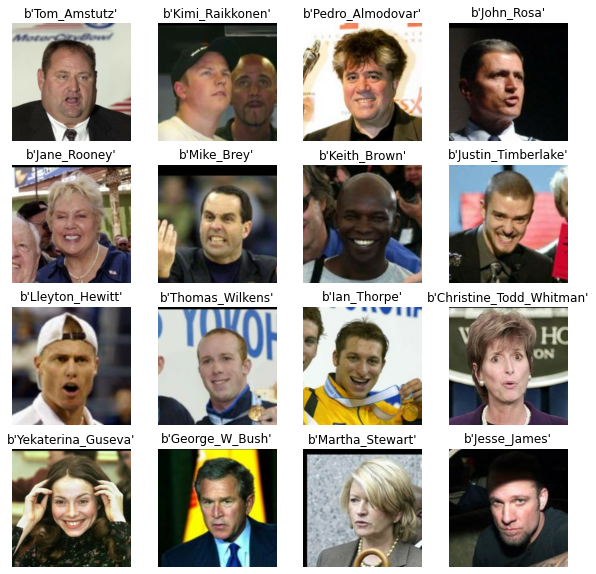

In [14]:
# посмотрим первые 16 картинок
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    ax = fig.add_subplot(4, 4, i+1)
    plt.imshow(train_x[i])
    plt.title(train_y[i])
    plt.axis("off")

In [15]:
def create_pairs(x, y):
    '''
    Функция для создания позитивных и негативных пар
    '''
    pairs = []
    labels = []

    unique = np.unique(y)
    digit_indices = [np.where(y == i)[0] for i in unique]
    negatives = list(filter(lambda x: len(x) == 1, digit_indices))
    positives = list(filter(lambda x: len(x) >= 2, digit_indices))
    for d in positives:
        for i in range(len(d) // 2):
            z1, z2 = d[i], d[i + 1]
            pairs += [[x[z1], x[z2]]]

            z1, z2 = random.choice(negatives)[0], random.choice(negatives)[0]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    pairs = np.array(pairs)
    labels = np.array(labels)
    return pairs,  labels

In [16]:
train_pairs, train_labels = create_pairs(train_x, train_y)

In [17]:
train_pairs.shape

(1402, 2, 224, 224, 3)

In [18]:
train_labels[0]

1

In [19]:
test_pairs, test_labels = create_pairs(test_x, test_y)

In [20]:
test_pairs.shape

(1184, 2, 224, 224, 3)

In [21]:
test_labels[0]

1

In [22]:
def show_image(image):
  """
  Визуализация одной картинки
  """
  plt.figure()
  plt.imshow(image)
  plt.colorbar()
  plt.grid(False)
  plt.show()

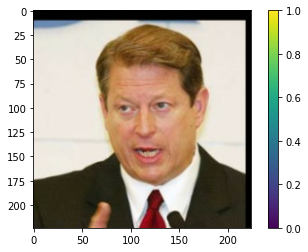

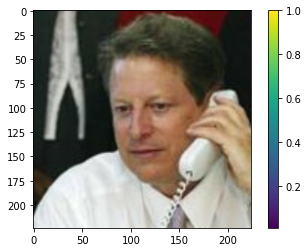

b'Ian_Thorpe' 1


In [23]:
# посмотрим картинки для пары 10
this_pair = 10
show_image(train_pairs[this_pair][0])
show_image(train_pairs[this_pair][1])
print(train_y[this_pair], train_labels[this_pair])

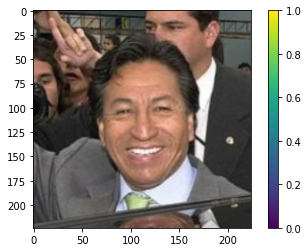

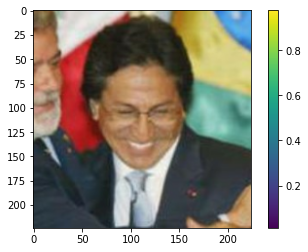

b'John_Marburger' 1


In [24]:
# посмотрим картинки для пары 20
this_pair = 20
show_image(train_pairs[this_pair][0])
show_image(train_pairs[this_pair][1])
print(train_y[this_pair], train_labels[this_pair])

В качестве базовой модели используем MobileNetV2

In [25]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(INP_SIZE, INP_SIZE, 3), include_top=False, weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [26]:
# Fine-tuning весов предобученной модели
base_model.trainable = True

In [27]:
# добавим два выходных слоя - пулинг и полносвязный без активации с выходным вектором размерности 256
b_model = tf.keras.Sequential([base_model, tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation=None)])

Создадим сиамскую модель

In [28]:
# Выходной размер
input_shape = train_pairs.shape[2:]
input_shape

(224, 224, 3)

In [29]:
# Параллельные процессы модели
input_a = tf.keras.layers.Input(input_shape, name="Left_input")
processed_a = b_model(input_a)
input_b = tf.keras.layers.Input(input_shape, name="Right_input")
processed_b = b_model(input_b)

In [30]:
@tf.function
def euclidean_distance(vects):
  """
  Евклидово расстояние. Создаем как tf функцию, для применения в моделях
  """
  x, y = vects
  sum_square = tf.reduce_sum(tf.square(x - y), axis=1, keepdims=True)
  return tf.sqrt(tf.maximum(sum_square, tf.keras.backend.epsilon()))

In [31]:
# Вычисление дистанции между векторами для сиамской модели
distance = tf.keras.layers.Lambda(euclidean_distance)([processed_a, processed_b])

In [32]:
# Сиамская модель. На входе у нас две картинки, на выходе модели дистанция между векторами.
model = tf.keras.models.Model([input_a, input_b], outputs=distance)

In [33]:
# Оптимизатор
optim = tf.keras.optimizers.Adam(learning_rate=0.002)

In [34]:
# создадим вспомогательные функции

@tf.function
def contrastive_loss(y_true, D, margin = 1):
  """
  сравнение близости двух векторов на основании евклидова расстояния
  y_true - истинное расстояние между векторами (1 или 0)
  margin - максимально возможное расстояние между векторами
  D = ||y1 - y2||
  """
  Y_true = tf.cast(y_true, tf.float32)
  return tf.reduce_mean(Y_true * tf.square(D) + (1-Y_true) * tf.maximum((margin-D),0))

@tf.function
def accuracy_sim(y_true, y_pred, threshold=0.5):
  """
  функция для вычисления точности предсказания
  """
  y_thresholded = tf.cast(y_pred > threshold, "float32")
  return tf.reduce_mean(tf.cast(tf.equal(y_true, y_thresholded), "float32"))

In [35]:
# Собираем модель
model.compile(loss=contrastive_loss, optimizer=optim, metrics=[accuracy_sim])

Тренировка модели

In [36]:
%%time
history = model.fit([train_pairs[:, 0], train_pairs[:, 1]], train_labels, batch_size=32, epochs=5)

Epoch 1/5
44/44 [==============================] - 71s 754ms/step - loss: 11.8608 - accuracy_sim: 0.4849
Epoch 2/5
44/44 [==============================] - 31s 713ms/step - loss: 0.3731 - accuracy_sim: 0.4287
Epoch 3/5
44/44 [==============================] - 31s 711ms/step - loss: 0.2941 - accuracy_sim: 0.3440
Epoch 4/5
44/44 [==============================] - 31s 711ms/step - loss: 0.2336 - accuracy_sim: 0.2354
Epoch 5/5
44/44 [==============================] - 31s 706ms/step - loss: 0.1993 - accuracy_sim: 0.2191
CPU times: user 1min 32s, sys: 57.1 s, total: 2min 29s
Wall time: 3min 17s


In [38]:
def plot_training(H):
	"""
  функция для построения графика тренировки
  """
	plt.style.use("ggplot")
	plt.figure()
	plt.plot(H.history["loss"], label="train_loss")
	#plt.plot(H.history["val_loss"], label="val_loss")
	plt.title("Training Loss")
	plt.xlabel("Epoch #")
	plt.ylabel("Loss")
	plt.legend(loc="lower left")

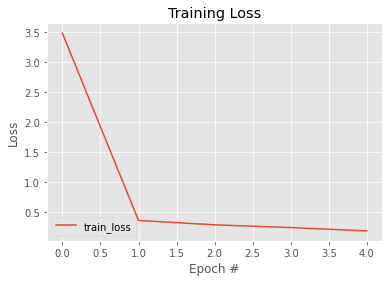

In [39]:
# график тренировки
plot_training(history)

In [40]:
# сделаем тестовое предсказание
y_pred = model.predict([test_pairs[:, 0], test_pairs[:, 1]])

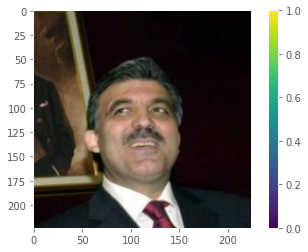

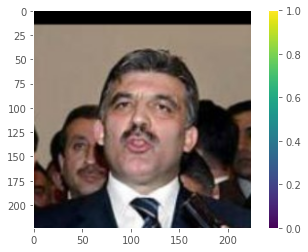

1
[1.6481304]
1


In [71]:
this_pair = 2
show_image(test_pairs[this_pair][0])
show_image(test_pairs[this_pair][1])
print(test_labels[this_pair])
print(y_pred[this_pair])
print(1 if y_pred[this_pair]<2 else 0)